# N2C2 Challege CNN-BiLSTM-CRF Model

## Importing Libraries

In [1]:
## Importing all required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras  # keras版本 2.3.1

Using TensorFlow backend.


In [2]:
import tensorflow as tf  # tensorflow版本 2.0.0

## Loading Data

In [3]:
# 读入train和dev，将空的word去掉
train_data = pd.read_csv("train.csv", encoding="iso-8859-1", header=0, index_col=0).dropna(subset=['Word'])
dev_data = pd.read_csv("dev.csv", encoding="iso-8859-1", header=0, index_col=0).dropna(subset=['Word'])
# test_data = pd.read_csv("test.csv", encoding="iso-8859-1", header=0, index_col=0).dropna(subset=['Word'])

In [4]:
#  只取Sentenceid，word，pos，label （实际上POS还未应用到模型中，这样做为了方便日后更新模型，加入POS）
train_data = train_data[['SentenceId', 'Word', 'POS', 'Label']]
dev_data = dev_data[['SentenceId', 'Word', 'POS', 'Label']]
train_data.columns = ['Sentence #','Word', 'Pos', 'Tag']
dev_data.columns = ['Sentence #','Word', 'Pos', 'Tag']

In [5]:
# 去掉所有的O（这是错误的）
train_data = train_data[train_data.Tag != 'O']
dev_data = dev_data[dev_data.Tag != 'O']

In [6]:
train_data.head()

,Sentence #,Word,Pos,Tag
notesId,,,,
101-01,101-01_13,Lipitor,PROPN,B
101-01,101-01_40,Synthroid,PROPN,B
101-02,101-02_14,Hydrochlorothiazide,PROPN,B
101-02,101-02_14,atenolol,NOUN,B
101-02,101-02_29,hydrochlorothiazide,ADJ,B


In [7]:
train_data.shape, dev_data.shape

((6800, 4), (0, 4))

In [8]:
# 手动split
# shuffle the dataset 
shuffled = train_data.sample(frac=1, random_state=20)

# define a size for the train set 
train_size = int(0.9 * len(train_data))

# split the data into train and test 
train_data = shuffled[:train_size]
dev_data = shuffled[train_size:]

In [9]:
train_data.shape, dev_data.shape

((6120, 4), (680, 4))

## Constructing Word to Index and Tag to Index Mappings

该部分详细请参见安老师的代码：NER_BiLSTM_CRF_annotated_corpus_NER

In [10]:
def to_tuples(data):
    iterator = zip(data["Word"].values.tolist(),
                   data["Pos"].values.tolist(),
                   data["Tag"].values.tolist())
    return [(word, pos, tag) for word, pos, tag in iterator]

In [11]:
# 将每个word作为向量，向量元素为其包含的char的index
def char(sentences, char2index):
    char_X = [[[char for char in word[0]] for word in sentence] for sentence in sentences]
    char_X = [[[char2index[char] if char in char2index.keys() else char2index["--UNKNOWN_CHAR--"] for char in word] for word in sentence] for sentence in char_X]
    char_X = [sentence + [[char2index["--PADDING--"]]] * (MAX_SENTENCE - len(sentence)) for sentence in char_X]
    char_X = [[word + [char2index["--PADDING--"]] * (MAX_CHAR - len(word)) for word in sentence] for sentence in char_X]
    
    return np.array(char_X)

In [12]:
def word(sentences, word2index):
    word_X = [[word[0] for word in sentence] for sentence in sentences]
    word_X = [[word2index[word] for word in sentence] for sentence in word_X]
    word_X = [sentence + [word2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in word_X]
    
    return np.array(word_X)

In [13]:
def tag(sentences, tag2index):
    y = [[word[2] for word in sentence] for sentence in sentences]
    y = [[tag2index[tag] for tag in sentence] for sentence in y]
    y = [sentence + [tag2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in y]
    TAG_COUNT = len(tag2index)
    y = [ np.eye(TAG_COUNT)[sentence] for sentence in y]
    
    return np.array(y)

In [14]:
MAX_CHAR = train_data.Word.apply(len).max()
MAX_SENTENCE = train_data.groupby("Sentence #")["Word"].agg(["count"]).max()[0]
# 自己建的char库，可修改
all_chars = " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|"  
# word和Tag库即为数据集里所有出现的word和tag
all_words = list(set(train_data["Word"].values).union(dev_data["Word"].values))
all_tags = list(set(train_data["Tag"].values).union(dev_data["Tag"].values))

char2index = {char: idx + 2 for idx, char in enumerate(all_chars)}
char2index["--UNKNOWN_CHAR--"]=0
char2index["--PADDING--"]=1
index2char = {idx: char for char, idx in char2index.items()}

word2index = {word: idx + 2 for idx, word in enumerate(all_words)}
word2index["--UNKNOWN_WORD--"]=0
word2index["--PADDING--"]=1
index2word = {idx: word for word, idx in word2index.items()}

tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index["--PADDING--"] = 0
index2tag = {idx: word for word, idx in tag2index.items()}

sentences_train = train_data.groupby("Sentence #").apply(to_tuples).tolist()
sentences_dev = dev_data.groupby("Sentence #").apply(to_tuples).tolist()
# sentences_test = test_data.groupby("Sentence #").apply(to_tuples).tolist()

char_train = char(sentences_train, char2index)
word_train = word(sentences_train, word2index)
y_train = tag(sentences_train, tag2index)

char_dev = char(sentences_dev, char2index)
word_dev = word(sentences_dev, word2index)
y_dev = tag(sentences_dev, tag2index)
# char_test = char(sentences_test, char2index)
# word_test = word(sentences_test, word2index)
# y_test = tag(sentences_test, tag2index)

In [15]:
# word_train.shape, word_test.shape, char_train.shape, char_test.shape, y_train.shape, y_test.shape
word_train.shape, word_dev.shape, char_train.shape, char_dev.shape, y_train.shape, y_dev.shape

((3505, 18),
 (602, 18),
 (3505, 18, 24),
 (602, 18, 24),
 (3505, 18, 3),
 (602, 18, 3))

In [16]:
CHAR_COUNT = len(all_chars) + 2
WORD_COUNT = len(all_words) + 2
TAG_COUNT = len(all_tags) + 1
CHAR_EMBEDDING = 25
WORD_EMBEDDING = 50
FILTERS_NUMBER = 30
WINDOW_SIZE = 3
LSTM_UNITS = 50
LSTM_DROPOUT = 0.1
DENSE_UNITS = 100
BATCH_SIZE = 20
MAX_EPOCHS = 20

In [17]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras_contrib import losses, metrics
from keras import layers, optimizers
# Model definition
char_input = layers.Input(shape=(MAX_SENTENCE, MAX_CHAR,), name='char_input')  
# (sample, sentence, words)
char_embedding = layers.TimeDistributed(layers.Embedding(CHAR_COUNT, CHAR_EMBEDDING), name='char_embedding', input_shape=(MAX_SENTENCE, MAX_CHAR))(char_input)
# (sample, sentence, words, embedding)
char_cnn = layers.TimeDistributed(layers.Conv1D(FILTERS_NUMBER, WINDOW_SIZE, activation='tanh', padding='same'), name='char_conv')(char_embedding)
# (sample, sentence, words, 30)
char_pooling = layers.TimeDistributed(layers.MaxPool1D(pool_size=int(MAX_CHAR)), name='char_pooling')(char_cnn)
# (sample, sentence, 30)
char = TimeDistributed(layers.Flatten(), name='flatten')(char_pooling)

word_input = layers.Input(shape=(MAX_SENTENCE,), name='word_input')

word_embedding = layers.Embedding(WORD_COUNT, WORD_EMBEDDING, input_length=MAX_SENTENCE, name='word_embedding')(word_input)

concatenated = layers.concatenate([word_embedding, char], axis=-1, name='concatenate')

model = layers.Dropout(rate=0.5, name="drop_out")(concatenated)

model = layers.Bidirectional(layers.LSTM(LSTM_UNITS, recurrent_dropout=LSTM_DROPOUT, return_sequences=True), name='BiLSTM')(model)

model = layers.TimeDistributed(layers.Dense(DENSE_UNITS, activation="relu"), name='dense')(model)

crf_layer = CRF(units=TAG_COUNT, name='CRF')
output_layer = crf_layer(model)

ner_model = Model([char_input, word_input], output_layer, name='CNN_BiLSTM_CRF')

loss = losses.crf_loss
acc_metric = metrics.crf_accuracy
opt = optimizers.Adam(lr=0.001)

ner_model.compile(optimizer=opt, loss=loss, metrics=[acc_metric])

ner_model.summary()

2022-04-01 00:06:31.073822: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-01 00:06:31.074555: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "CNN_BiLSTM_CRF"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         (None, 18, 24)       0                                            
__________________________________________________________________________________________________
char_embedding (TimeDistributed (None, 18, 24, 25)   2375        char_input[0][0]                 
__________________________________________________________________________________________________
char_conv (TimeDistributed)     (None, 18, 24, 30)   2280        char_embedding[0][0]             
__________________________________________________________________________________________________
word_input (InputLayer)         (None, 18)           0                                            
_____________________________________________________________________________________

In [18]:
%%time
history = ner_model.fit([char_train, word_train], y_train, 
                        batch_size=BATCH_SIZE, epochs=MAX_EPOCHS, 
                        validation_data=([char_dev, word_dev], y_dev), 
                        verbose=2)

/Users/DELL/opt/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3505 samples, validate on 602 samples
Epoch 1/20
 - 21s - loss: 0.1384 - crf_accuracy: 0.9446 - val_loss: 0.0164 - val_crf_accuracy: 0.9917
Epoch 2/20
 - 17s - loss: 0.0169 - crf_accuracy: 0.9911 - val_loss: 0.0024 - val_crf_accuracy: 0.9948
Epoch 3/20
 - 17s - loss: -1.9958e-03 - crf_accuracy: 0.9968 - val_loss: -3.6775e-03 - val_crf_accuracy: 0.9965
Epoch 4/20
 - 15s - loss: -1.0966e-02 - crf_accuracy: 0.9978 - val_loss: -1.0027e-02 - val_crf_accuracy: 0.9960
Epoch 5/20
 - 16s - loss: -1.8410e-02 - crf_accuracy: 0.9982 - val_loss: -1.7326e-02 - val_crf_accuracy: 0.9960
Epoch 6/20
 - 16s - loss: -2.4918e-02 - crf_accuracy: 0.9983 - val_loss: -2.3295e-02 - val_crf_accuracy: 0.9960
Epoch 7/20
 - 16s - loss: -3.2363e-02 - crf_accuracy: 0.9984 - val_loss: -2.9964e-02 - val_crf_accuracy: 0.9960
Epoch 8/20
 - 17s - loss: -4.0229e-02 - crf_accuracy: 0.9986 - val_loss: -3.6547e-02 - val_crf_accuracy: 0.9961
Epoch 9/20
 - 17s - loss: -4.8442e-02 - crf_accuracy: 0.9984 - val_loss: -4.6

# History

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'CRF Accuracy'}, xlabel='Epochs', ylabel='CRF Accuracy'>],
       dtype=object))

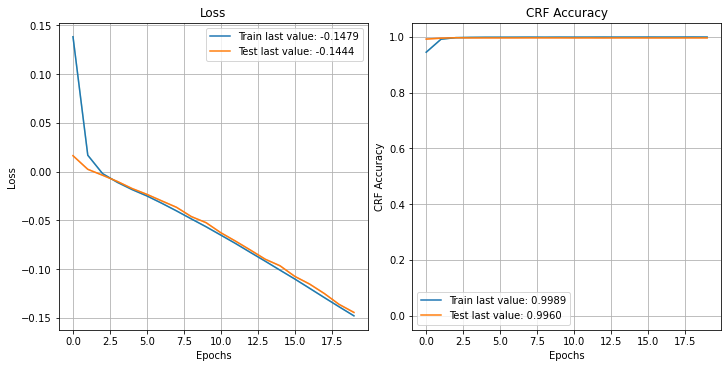

In [19]:
from plot_keras_history import plot_history
plot_history(history.history)

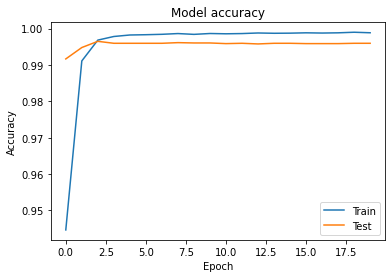

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['crf_accuracy'])
plt.plot(history.history['val_crf_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

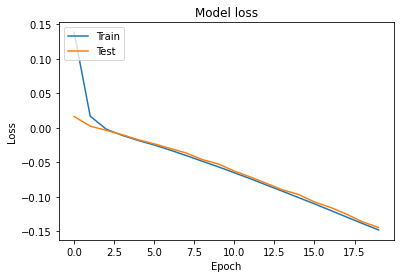

In [21]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluation